3 cartes chargées

Choisissez le pokemon 
1. pikatchu.jpg
2. Psykokwak.png
3. Ratata.png

Vous avez choisi : pikatchu.jpg


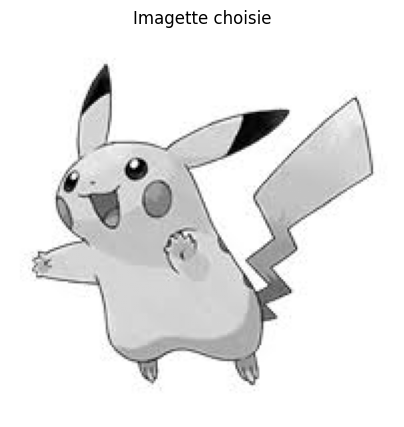


Pokémon reconnu : pikatchu_carte.jpg
Score : 0.0922


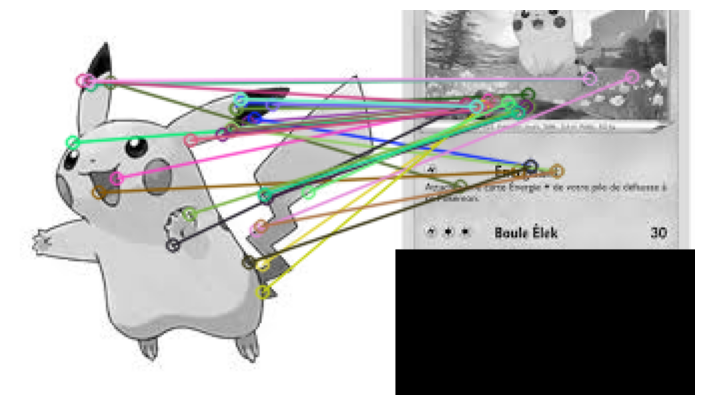

In [ ]:
import cv2
import os #Fonctions pour manipuler les dossier et fichier (fait partie de python pas besoin d'installer quoi que ce soit)
import numpy as np
import matplotlib.pyplot as plt


# Fonctions utilitaires

def Afficher (img, title="Image"):
    plt.figure(figsize=(5,5)) #pour l'affichage du pokemon (largeur, hauteur)
    plt.imshow(img, cmap='gray') #Besoin de cmap pour matplotlib pour un bon rendu visuel.
    plt.title(title)
    plt.axis('off')
    plt.show()

def crop_center(img, crop_ratio=0.6):
    h, w = img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    start_x = (w - new_w) // 2
    start_y = (h - new_h) // 2
    return img[start_y:start_y + new_h, start_x:start_x + new_w]


# Déclaration de la méthode ORB

orb = cv2.ORB_create(nfeatures=3000, scaleFactor=1.2, nlevels=8)

# Chargement banque d'image  'cartes'

def load_dataset(dataset_path):
    dataset = []
    for filename in os.listdir(dataset_path):
        path = os.path.join(dataset_path, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img_cropped = crop_center(img, crop_ratio=0.6)
        kp, desc = orb.detectAndCompute(img_cropped, None)
        if desc is not None:
            dataset.append({"filename": filename, "image": img_cropped, "keypoints": kp, "descriptors": desc})
    print(f"{len(dataset)} cartes chargées")
    return dataset

cards_dataset = load_dataset("data/carte")

# Choix de l'imagette

def choix_image(queries_folder="data/queries"):
    imagettes = [f for f in os.listdir(queries_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if not imagettes:
        raise ValueError("Aucune imagette trouvée.")
    print("\nChoisissez le pokemon ")
    for i,f in enumerate(imagettes):
        print(f"{i+1}. {f}")

    #Verification du nombre rentrerpour l'imagette
    while True:
        choix = input(f"Entrez le numéro (1-{len(imagettes)}): ")
        if choix.isdigit() and 1 <= int(choix) <= len(imagettes):
            choix = int(choix)-1
            break
        print("Entrée invalide, réessayez.")
    query_path = os.path.join(queries_folder, imagettes[choix])
    print(f"\nVous avez choisi : {imagettes[choix]}")
    query_img = cv2.imread(query_path, cv2.IMREAD_GRAYSCALE)
    if query_img is None:
        raise FileNotFoundError(f"Impossible de charger : {query_path}") #pas sur de le laisser ou trouver une autre solution.
    query_img = crop_center(query_img, crop_ratio=0.9)
    Afficher(query_img, "Imagette choisie") #Changer pour afficher
    return query_img

query_img = choix_image("data/imagette")


# Extraction des descripteurs ORB

q_kp, q_desc = orb.detectAndCompute(query_img, None)


# Matching ORB

def meilleur_match(query_desc, dataset, ratio=0.80): #jouez avec le ratio pour avoir le plus pres possible un résultat exact ! 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    best_match = None
    best_score = 0
    for data in dataset:
        matches = bf.knnMatch(query_desc, data["descriptors"], k=2)
        good_matches = [m for m,n in matches if m.distance < ratio*n.distance] #technique pour la reconnaissance 
        score = len(good_matches)/len(data["descriptors"])
        if score > best_score:
            best_score = score
            best_match = data
    return best_match, best_score

best_match, score = meilleur_match(q_desc, cards_dataset)


# Affichage résultats

THRESHOLD = 0.02
if score < THRESHOLD:
    print("\nAucune reconnaissance fiable")
else:
    print(f"\nPokémon reconnu : {best_match['filename']}")
    print(f"Score : {round(score,4)}")

    # Visualisation
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(q_desc, best_match["descriptors"])
    matches = sorted(matches, key=lambda x:x.distance)[:30]
    result = cv2.drawMatches(query_img, q_kp, best_match["image"], best_match["keypoints"], matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,5))
    plt.imshow(result)
    plt.axis('off')
    plt.show()
